# GISMA University of Applied Sciences

## M508B Big Data Analytics

## Assessment Brief by

## GH1039649 Berk HAKCIL

# Defining the Business Problem

The news agency company I am working for publishes thousands of articles with different topics every day. These articles should be classified for better user experience, recommendation system and targeted ads. Manually tagging each article is time consuming and is not scalable with large number of afticles. Automating this process will fasten and smoothen the companies landing page and create a better user experience which can lead to more traffic. This will also allow us to get more ads and elevate our position in the market. As an NLP task I will develop a machine learning based text classification system that classifies news articles into predefined categories. In this specific case I have a dataset of 120.000 values and 4 different classes as follows: 1-World, 2-Sports, 3-Business, 4-Sci/Tech

## Importing the Libraries for the Project

In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re #Using this module for preprocessing my title column
import spacy #Lemmatization for better generalizing
from sklearn.feature_extraction.text import TfidfVectorizer #Vectorizing my text for ML models
from sklearn.linear_model import LogisticRegression #4 ML models that attempted
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report #evaluation metrics
from sklearn.model_selection import GridSearchCV #hyperparameter tuning 
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud #creating a wordcloud for each label

## Loading and Explaining my Dataset

In [2]:
df = pd.read_csv("C:/Users/Berk/Desktop/news_articles.csv")
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Class index refers to: 1-World, 2-Sports, 3-Business, 4-Sci/Tech

I will change the Class Index to label and lowercase rest for easy implementation.

In [3]:
df.columns = ['label', 'title', 'description']

# Exploratory Data Analysis (EDA)

First I will check if there are any missing or duplicate values in my dataset.

In [4]:
print(df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

label          0
title          0
description    0
dtype: int64
Duplicates: 0


No missing or duplicate values we can move forward.

In [5]:
df.dtypes

label           int64
title          object
description    object
dtype: object

Down below I will check how many values are there in each class to see if I have a class imbalance error. Will plot a graph for easier understanding.

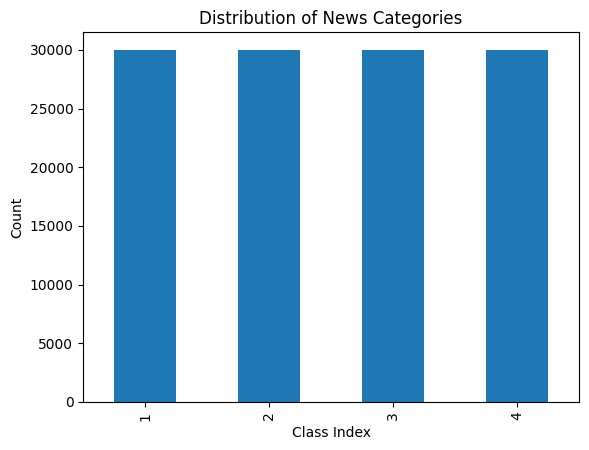

In [6]:
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of News Categories")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

As we can observe this dataset contains 120.000 values splitted into exact 4 categories and there are no duplicate or missing values. I declare that this dataset is suitable for my classification task and move forward.

## Splitting my dataset to Train, Test and Validation

Now I will split my dataset to prevent data leakage using scikit learn. I choose 70 training, 15 percent for validation and 15 percent for testing the chosen algorithm. 

In [29]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=None, random_state=42) #temp for creating val and test out of it
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=None, random_state=42) #None stratify because balanced dataset

In [8]:
print("Train shape: ", train_df.shape)
print("Temp shape: ", temp_df.shape)
print("Validation shape: ", val_df.shape)
print("Test shape: ", test_df.shape)

Train shape:  (84000, 3)
Temp shape:  (36000, 3)
Validation shape:  (18000, 3)
Test shape:  (18000, 3)


# Data Prepocessing

In this part I will tune my dataset to get in the correct format for training. I will start by dropping the columns I do not need.


In [9]:
df.drop(columns=['description'], inplace=True)

I will use RegEx module from python to standardize my text in the title column. Steps are lowercasing, removing none letter charachters and spaces.

In [10]:
def clean_text(text):
    text = text.lower() #lowercase the text
    text = re.sub(r'[^a-z\s]', '', text) #none letters and single space
    text = re.sub(r'\s+', ' ', text).strip() #if there are more than single space
    return text

df['clean_title'] = df['title'].apply(clean_text)

In [11]:
df.clean_title.head()

0       wall st bears claw back into the black reuters
1    carlyle looks toward commercial aerospace reuters
2         oil and economy cloud stocks outlook reuters
3    iraq halts oil exports from main southern pipe...
4    oil prices soar to alltime record posing new m...
Name: clean_title, dtype: object

I am *not* removing stopwords since it is already built in TF-IDF Vectorizer. Down below I will use lemmatization function from spacy for improving generalization on a fairly large dataset. Defining a lemmatize funtion that creates a list of lemmas (token.lemma_) for tokens that are not stop words after that returns that by joining them.

In [12]:
nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

df['clean_title'] = df['clean_title'].apply(lemmatize)

Now I can split the dataset for Modeling since I have applied preprocessing.

In [13]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=None, random_state=42) #temp for creating val and test out of it
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=None, random_state=42) #None stratify because balanced dataset

In the cell below I will print both columns to see how my preprocessing went. Then I will drop the title column for usind my df in modeling.

In [14]:
df.head()

,label,title,clean_title
0,3,Wall St. Bears Claw Back Into the Black (Reuters),wall st bear claw black reuter
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle look commercial aerospace reuter
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),oil economy cloud stock outlook reuter
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halt oil export main southern pipeline re...
4,3,"Oil prices soar to all-time record, posing new...",oil price soar alltime record pose new menace ...


In [15]:
df = df.drop(columns=['title'])

In [16]:
df.head()

,label,clean_title
0,3,wall st bear claw black reuter
1,3,carlyle look commercial aerospace reuter
2,3,oil economy cloud stock outlook reuter
3,3,iraq halt oil export main southern pipeline re...
4,3,oil price soar alltime record pose new menace ...


The dataset is ready for modeling.

# Modeling

In this part I will test some machine learning models to see which fits my goals and dataset better using evaloutaion metrics on the validation set. My features are in clean_title column (text) my target is label (integer 1 to 4) column. 

## Text Vectorization

Here I need to convert my text into numerical values that the ML model I picked can understand and Tfidf Vectorizer is the method I chose. Considerind top 10.000 features and uni-bigrams.

In [ ]:
# Vectorization with 10.000 features for uni-bigrams
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['clean_title'])
X_val = vectorizer.transform(val_df['clean_title'])
X_test = vectorizer.transform(test_df['clean_title'])

# Label conversion (1-4 → 0-3) some models might expect zero
y_train = train_df['label'] - 1
y_val = val_df['label'] - 1
y_test = test_df['label'] - 1

If my label column contained any text value here I should do encoding but since my target is already and integer 1-4 I will not need encoding.

Now I will define each model and create a for loop for considering which model that I will pick based on my evaluation metrics.

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr'),
    "Linear SVM": LinearSVC(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Multinomial NB": MultinomialNB()
}

# Loop over models, train, and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted')
    
    print(f"{name}: Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

C:\Users\Berk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression: Accuracy=0.8554, Precision=0.8556, Recall=0.8554, F1=0.8551
Linear SVM: Accuracy=0.8590, Precision=0.8591, Recall=0.8590, F1=0.8588
Random Forest: Accuracy=0.8128, Precision=0.8141, Recall=0.8128, F1=0.8127
Multinomial NB: Accuracy=0.8478, Precision=0.8476, Recall=0.8478, F1=0.8476


After rewieving the results Linear SVM shows better performance metrics acrross the board. My main focus was the weighted F1 score since it gives the most information on this classification task. With 0.8588 score that is the ML model I will be moving forward with.

## Hyperparameter Tuning

In this part I will focus on the ML algorithm I chose and improve my evaluation metrics by tuning hyperparameters. Before testing on the actual test set will chechk the optimal parameters with the validation set.

Created a grid search cell for the Linear support vector classification with the default changing parameters to see which fits my scenario better before testing on the actual set.

In [21]:
param_grid = {
    'C': [0.01, 0.1, 1, 10], #Regularization Strength if it is larger it fits better
    'loss': ['squared_hinge'],  #loss function to weigh the wrong predictions
    'max_iter': [1000, 2000], #number of steps
    'tol': [1e-4, 1e-3] #tolerance on error too small error can slow down my calculation
}

svc = LinearSVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.0001}


Now I will use the optimal parameters to see the perfomance of my model on the validation set before moving on to the test set.

In [22]:
optimal_model = grid_search.best_estimator_
val_accuracy = optimal_model.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.859


Down below I will observe classification report.

In [24]:
y_val_pred = optimal_model.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      4483
           1       0.87      0.92      0.89      4496
           2       0.83      0.83      0.83      4455
           3       0.85      0.83      0.84      4566

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000



Here we can observe how better parameters improved my overall classification report. Mainly my f1-score was important on this case and it got better with the optimal model.

## Testing the Model on the Unseen Test Set

This part will demonstrate my models performance on the actual test set. It will highlight weaknesses and elaborate the results with visualization and explanations.

First I will see the classification report for my test set.

In [32]:
y_test_pred = optimal_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4449
           1       0.87      0.92      0.89      4600
           2       0.83      0.83      0.83      4488
           3       0.84      0.83      0.83      4463

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000



I will create a confusion matrix to observe the weak spots of my model, I will convert the label points into their respected original name.

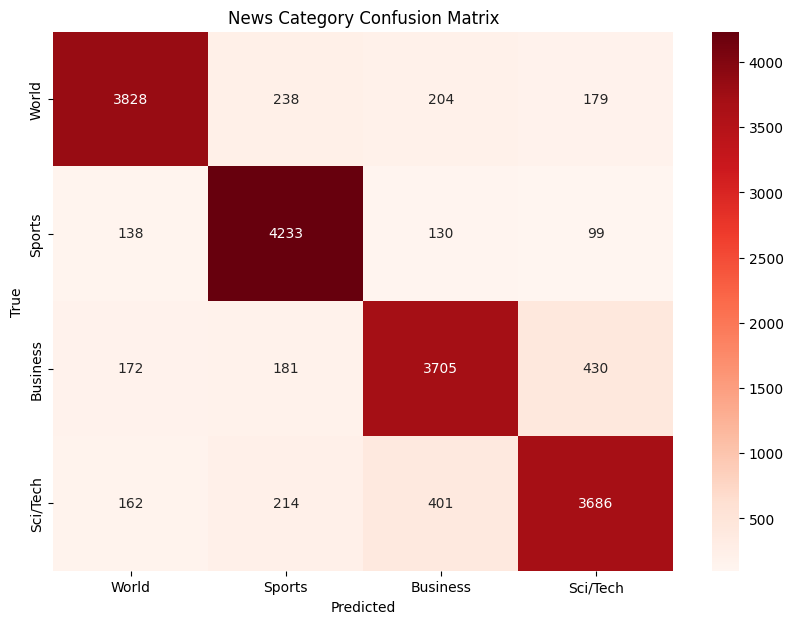

In [41]:
#I will turn my label names back to original
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']

#Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

#Plot my graph with figure size 10 to 7 and create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=label_names, 
            yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('News Category Confusion Matrix')
plt.show()

Here we can observe the weak spot is in the classification of Business and SCİ/Tech around 400 confusion in both cases. This might be happening due to similarities of the 2 topic in real life. It is integrated with each other most of the time. However the overall performance of the model is decent.

Now I will show the top keywords per class to observe which words gave me the most information gain and how they are in each class. 

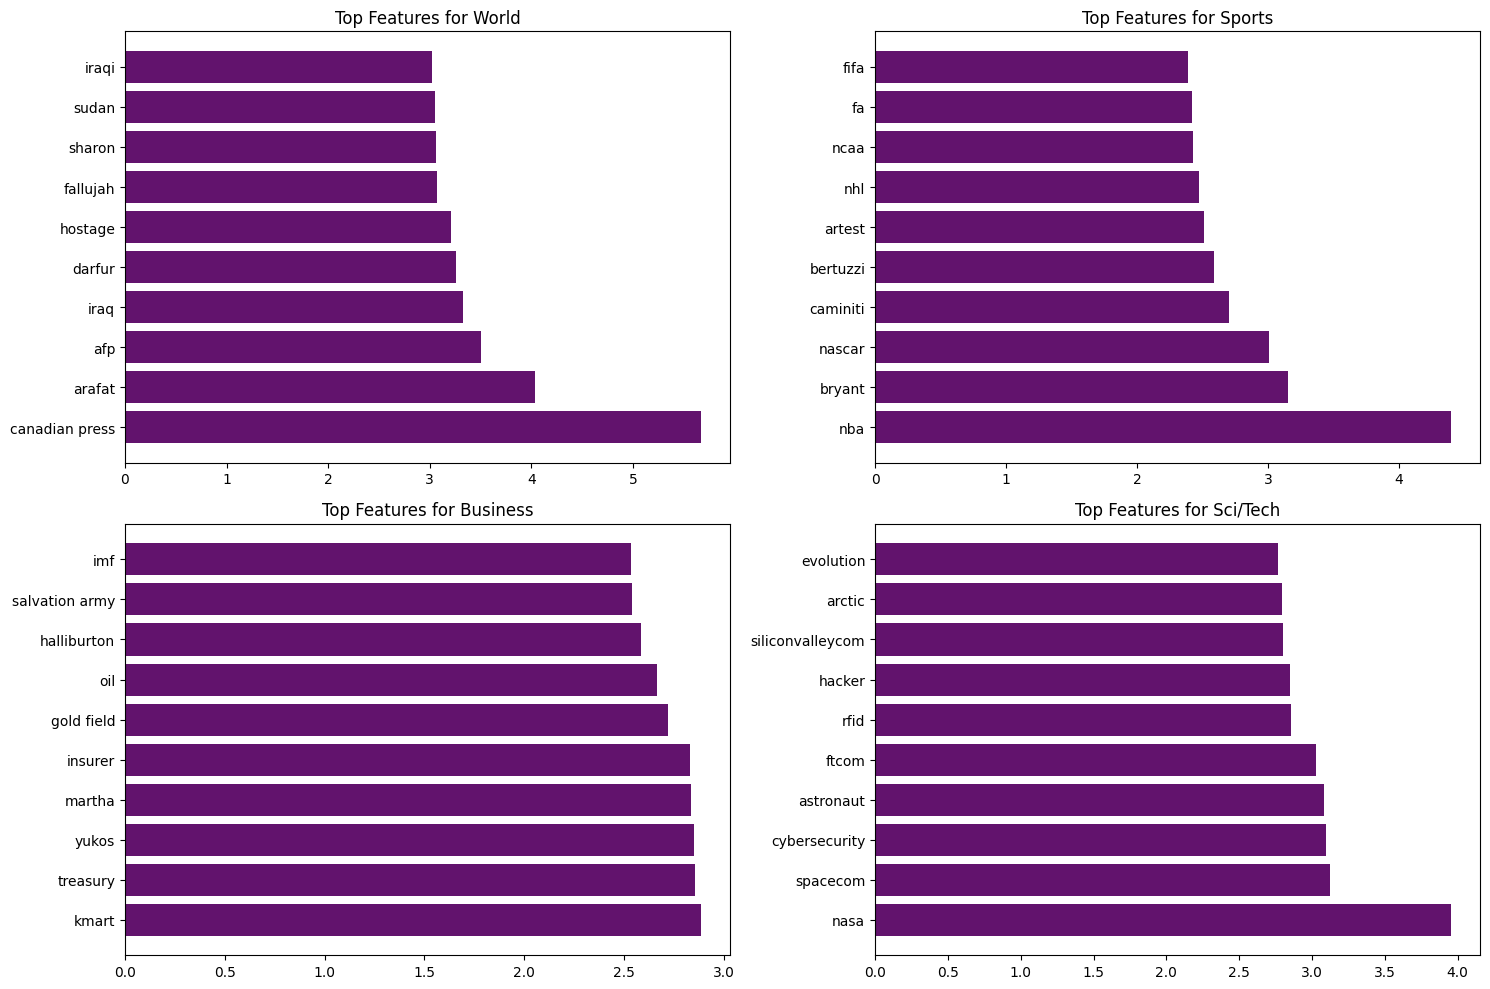

In [46]:
feature_names = vectorizer.get_feature_names_out() #This gets the feature names from TF-IDF vectorizer, array of all words (e.g., ['game', 'economy', ...])

plt.figure(figsize=(15, 10)) #Created a 15x10 inch figure
for i, label in enumerate(label_names): #I created a Loop through each news category
    #Geting indices of top 10 most important words for this category
    #- optimal_model.coef_[i] gives importance scores for class i
    #- argsort()[-10:][::-1] gets indices of top 10 scores (descending)
    top_features = np.argsort(optimal_model.coef_[i])[-10:][::-1]  # Top 10 features
    plt.subplot(2, 2, i+1) #Created a subplot for this category 2x2 grid, position i+1
    plt.barh(feature_names[top_features], optimal_model.coef_[i][top_features], color=["#62136d"])
    plt.title(f'Top Features for {label}')
plt.tight_layout()
plt.show()

This is a remarkable info regarding our news. In the worlds category canadian press takes the lead followed by middle east terms. In the sports class NBA bryant and nascar is the top 3. In the Business section there is no clear difference but kmart and treasury seems the gice the most information. In the Sci/Tech section NASA is leading with quite the difference. These results show us which words are most important while categorizing our news.

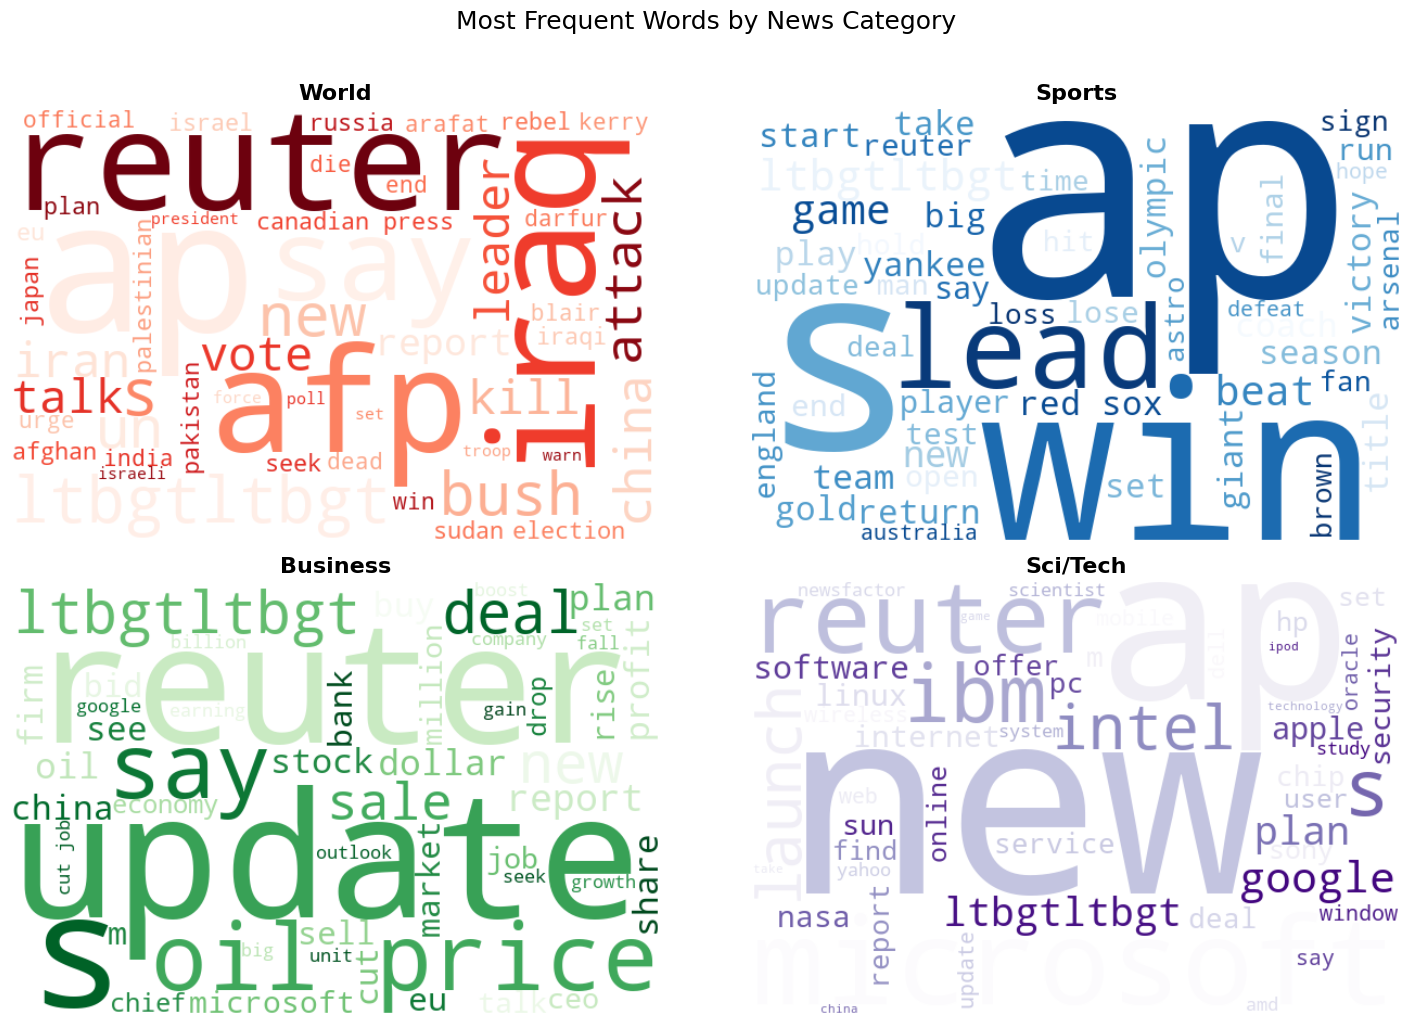

In [ ]:
label_texts = {
    'World': ' '.join(train_df[train_df['label'] == 1]['clean_title']), #adjusting my labels back to original text
    'Sports': ' '.join(train_df[train_df['label'] == 2]['clean_title']),
    'Business': ' '.join(train_df[train_df['label'] == 3]['clean_title']),
    'Sci/Tech': ' '.join(train_df[train_df['label'] == 4]['clean_title'])
}
#Defining the color maps for each category of the df
colormaps = {
    'World': 'Reds',
    'Sports': 'Blues',
    'Business': 'Greens',
    'Sci/Tech': 'Purples'
}

plt.figure(figsize=(15, 10))
for i, (label, text) in enumerate(label_texts.items()): #creating the word cloud for my labels
    wc = WordCloud(
        width=600, #size and background
        height=400,
        background_color='white',
        colormap=colormaps[label],  #using the label texts function to color individually
        max_words=50, #how much I want to display
        contour_width=1, #creating borders for better visibility
        contour_color='steelblue'
    ).generate(text)
    
    plt.subplot(2, 2, i+1) #creating a subplot at i+1
    plt.imshow(wc, interpolation='bilinear') #smoother visuals for my image
    plt.title(label, fontdict={'fontsize': 16, 'fontweight': 'bold'}) #making the title bold
    plt.axis('off') #for hiding the axes
 
plt.suptitle('Most Frequent Words by News Category', y=1.02, fontsize=18)
plt.tight_layout() #to not see overlapping
plt.savefig('wordclouds.png', dpi=300, bbox_inches='tight') #configuring the resouliton 
plt.show()

This results highlights each labels inside information. We can observe the frequiency of the words that are important for each category. This also gives us insights for our news.

## Final Discussion and Comments on the Pipeline

With this pipeline operating in our server we can classify each news article to 4 categories automatically. The strenght of this pipeline is it fast so we can deploy it without latency. Implement on many articles the company has each day without manually reviewing every single one of them. The UI can be adjusted with the recommended section with gathering data from the users. Meaning we can recommend same type of news depending on the visitors preferences. The accuracy might be improved by using different approaches such as new algorithms or larger dataset. 



This project can be submitted to the lead data scientist of the company for review. Based on the feedback improvements and modifications can be made. With this calssifier we can save time and labor for the company. 